# Show data about MEV relay registrations
See .env.example to set the environment variables.

In [1]:
!pip install jupysql clickhouse_sqlalchemy matplotlib pandas python-dotenv seaborn > /dev/null 2>&1

In [2]:
import dotenv
import os

dotenv.load_dotenv()
network = os.getenv('NETWORK')
print(f"network: {network}")

network: mainnet


In [3]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sqlalchemy import text
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')


%matplotlib inline



In [4]:
# Connect to ClickHouse
import os
from sqlalchemy import create_engine

username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')

print(f"username: {username}")
print(f"host: {host}")

db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"
engine = create_engine(db_url)
connection = engine.connect()

username: pandaops
host: clickhouse.xatu.ethpandaops.io


In [5]:
# -- Create temporary table with new partitioning and ordering
# CREATE TABLE IF NOT EXISTS tmp.mev_relay_validator_registration_local ON CLUSTER '{cluster}' (
#     `updated_date_time` DateTime COMMENT 'Timestamp when the record was last updated' CODEC(DoubleDelta, ZSTD(1)),
#     `event_date_time` DateTime64(3) COMMENT 'When the registration was fetched' CODEC(DoubleDelta, ZSTD(1)),
#     `timestamp` Int64 COMMENT 'The timestamp of the registration' CODEC(DoubleDelta, ZSTD(1)),
#     `relay_name` String COMMENT 'The relay that the registration was fetched from' CODEC(ZSTD(1)),
#     `validator_index` UInt32 COMMENT 'The validator index of the validator registration' CODEC(ZSTD(1)),
#     `gas_limit` UInt64 COMMENT 'The gas limit of the validator registration' CODEC(DoubleDelta, ZSTD(1)),
#     `fee_recipient` String COMMENT 'The fee recipient of the validator registration' CODEC(ZSTD(1)),
#     `slot` UInt32 COMMENT 'Slot number derived from the validator registration `timestamp` field' CODEC(DoubleDelta, ZSTD(1)),
#     `slot_start_date_time` DateTime COMMENT 'The slot start time derived from the validator registration `timestamp` field' CODEC(DoubleDelta, ZSTD(1)),
#     `epoch` UInt32 COMMENT 'Epoch number derived from the validator registration `timestamp` field' CODEC(DoubleDelta, ZSTD(1)),
#     `epoch_start_date_time` DateTime COMMENT 'The epoch start time derived from the validator registration `timestamp` field' CODEC(DoubleDelta, ZSTD(1)),
#     `wallclock_slot` UInt32 COMMENT 'The wallclock slot when the request was sent' CODEC(DoubleDelta, ZSTD(1)),
#     `wallclock_slot_start_date_time` DateTime COMMENT 'The start time for the slot when the request was sent' CODEC(DoubleDelta, ZSTD(1)),
#     `wallclock_epoch` UInt32 COMMENT 'The wallclock epoch when the request was sent' CODEC(DoubleDelta, ZSTD(1)),
#     `wallclock_epoch_start_date_time` DateTime COMMENT 'The start time for the wallclock epoch when the request was sent' CODEC(DoubleDelta, ZSTD(1)),
#     `meta_client_name` LowCardinality(String) COMMENT 'Name of the client that generated the event',
#     `meta_client_id` String COMMENT 'Unique Session ID of the client that generated the event. This changes every time the client is restarted.' CODEC(ZSTD(1)),
#     `meta_client_version` LowCardinality(String) COMMENT 'Version of the client that generated the event',
#     `meta_client_implementation` LowCardinality(String) COMMENT 'Implementation of the client that generated the event',
#     `meta_client_os` LowCardinality(String) COMMENT 'Operating system of the client that generated the event',
#     `meta_client_ip` Nullable(IPv6) COMMENT 'IP address of the client that generated the event' CODEC(ZSTD(1)),
#     `meta_client_geo_city` LowCardinality(String) COMMENT 'City of the client that generated the event' CODEC(ZSTD(1)),
#     `meta_client_geo_country` LowCardinality(String) COMMENT 'Country of the client that generated the event' CODEC(ZSTD(1)),
#     `meta_client_geo_country_code` LowCardinality(String) COMMENT 'Country code of the client that generated the event' CODEC(ZSTD(1)),
#     `meta_client_geo_continent_code` LowCardinality(String) COMMENT 'Continent code of the client that generated the event' CODEC(ZSTD(1)),
#     `meta_client_geo_longitude` Nullable(Float64) COMMENT 'Longitude of the client that generated the event' CODEC(ZSTD(1)),
#     `meta_client_geo_latitude` Nullable(Float64) COMMENT 'Latitude of the client that generated the event' CODEC(ZSTD(1)),
#     `meta_client_geo_autonomous_system_number` Nullable(UInt32) COMMENT 'Autonomous system number of the client that generated the event' CODEC(ZSTD(1)),
#     `meta_client_geo_autonomous_system_organization` Nullable(String) COMMENT 'Autonomous system organization of the client that generated the event' CODEC(ZSTD(1)),
#     `meta_network_name` LowCardinality(String) COMMENT 'Ethereum network name',
#     `meta_labels` Map(String, String) COMMENT 'Labels associated with the event' CODEC(ZSTD(1))
# ) ENGINE = ReplicatedReplacingMergeTree(
#     '/clickhouse/{installation}/{cluster}/{database}/tables/{table}/{shard}',
#     '{replica}',
#     updated_date_time
# ) PARTITION BY toStartOfMonth(event_date_time)
# ORDER BY
#     (
#         event_date_time,
#         meta_network_name,
#         meta_client_name,
#         relay_name,
#         validator_index,
#         timestamp
#     ) COMMENT 'Contains MEV relay validator registrations data.';

# CREATE TABLE default.mev_relay_validator_registration ON CLUSTER '{cluster}' AS default.mev_relay_validator_registration_local ENGINE = Distributed(
#     '{cluster}',
#     default,
#     mev_relay_validator_registration_local,
#     cityHash64(
#         slot,
#         meta_network_name
#     )
# );


In [6]:
# Define the filtering time range
start_date = '2024-12-20 00:00:00'
end_date = '2025-01-31 23:59:59'

print(f"Filtering results between {start_date} and {end_date} on {network}")

Filtering results between 2024-12-20 00:00:00 and 2025-01-31 23:59:59 on mainnet


In [7]:
validator_query = text("""
    SELECT 
        `index` as validator_index,
        entity
    FROM ethseer_validator_entity
    WHERE 
        meta_network_name = :network
""")
validator_entities = pd.DataFrame(
    connection.execute(validator_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', ''), "network": network}).fetchall(),
    columns=['validator_index', 'entity']
)
validator_entities

,validator_index,entity
0,88035,whale_0x3230
1,196370,abyss_finance
2,196382,abyss_finance
3,196384,abyss_finance
4,196388,abyss_finance
...,...,...
1535620,983558,rocketpool
1535621,983572,solo_stakers
1535622,983573,solo_stakers
1535623,983671,solo_stakers


In [8]:
query = text("""
    SELECT
        validator_index,
        slot,
        gas_limit,
        timestamp,
        relay_name
    FROM
        mev_relay_validator_registration
    WHERE
        event_date_time >= :start_date
        AND event_date_time < :end_date
        AND meta_network_name = :network
    GROUP BY
        validator_index,
        slot,
        gas_limit,
        timestamp,
        relay_name
    ORDER BY
        slot,
        validator_index,
        relay_name
""")

registrations = pd.read_sql(query, connection, params={"start_date": start_date, "end_date": end_date, "network": network})

# Add proposer entity to registrations
registrations = registrations.merge(validator_entities, on='validator_index', how='left')
registrations

,validator_index,slot,gas_limit,timestamp,relay_name,entity
0,494481,0,30000000,1606824023,Aestus,solo_stakers
1,494481,0,30000000,1606824023,Agnostic Gnosis,solo_stakers
2,494481,0,30000000,1606824023,Flashbots,solo_stakers
3,494481,0,30000000,1606824023,Titan Relay,solo_stakers
4,494481,0,30000000,1606824023,Ultra Sound,solo_stakers
...,...,...,...,...,...,...
12965108,557990,10782304,30000000,1736211671,Eden Network,xhash
12965109,557990,10782304,30000000,1736211671,Titan Relay,xhash
12965110,1255908,10782304,30000000,1736211671,BloXroute Max Profit,infstones
12965111,1255908,10782304,30000000,1736211671,BloXroute Regulated,infstones


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_16789/1311212634.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  registrations_month['validator_bucket'] = registrations_month['validator_index'] // validator_bucket_size


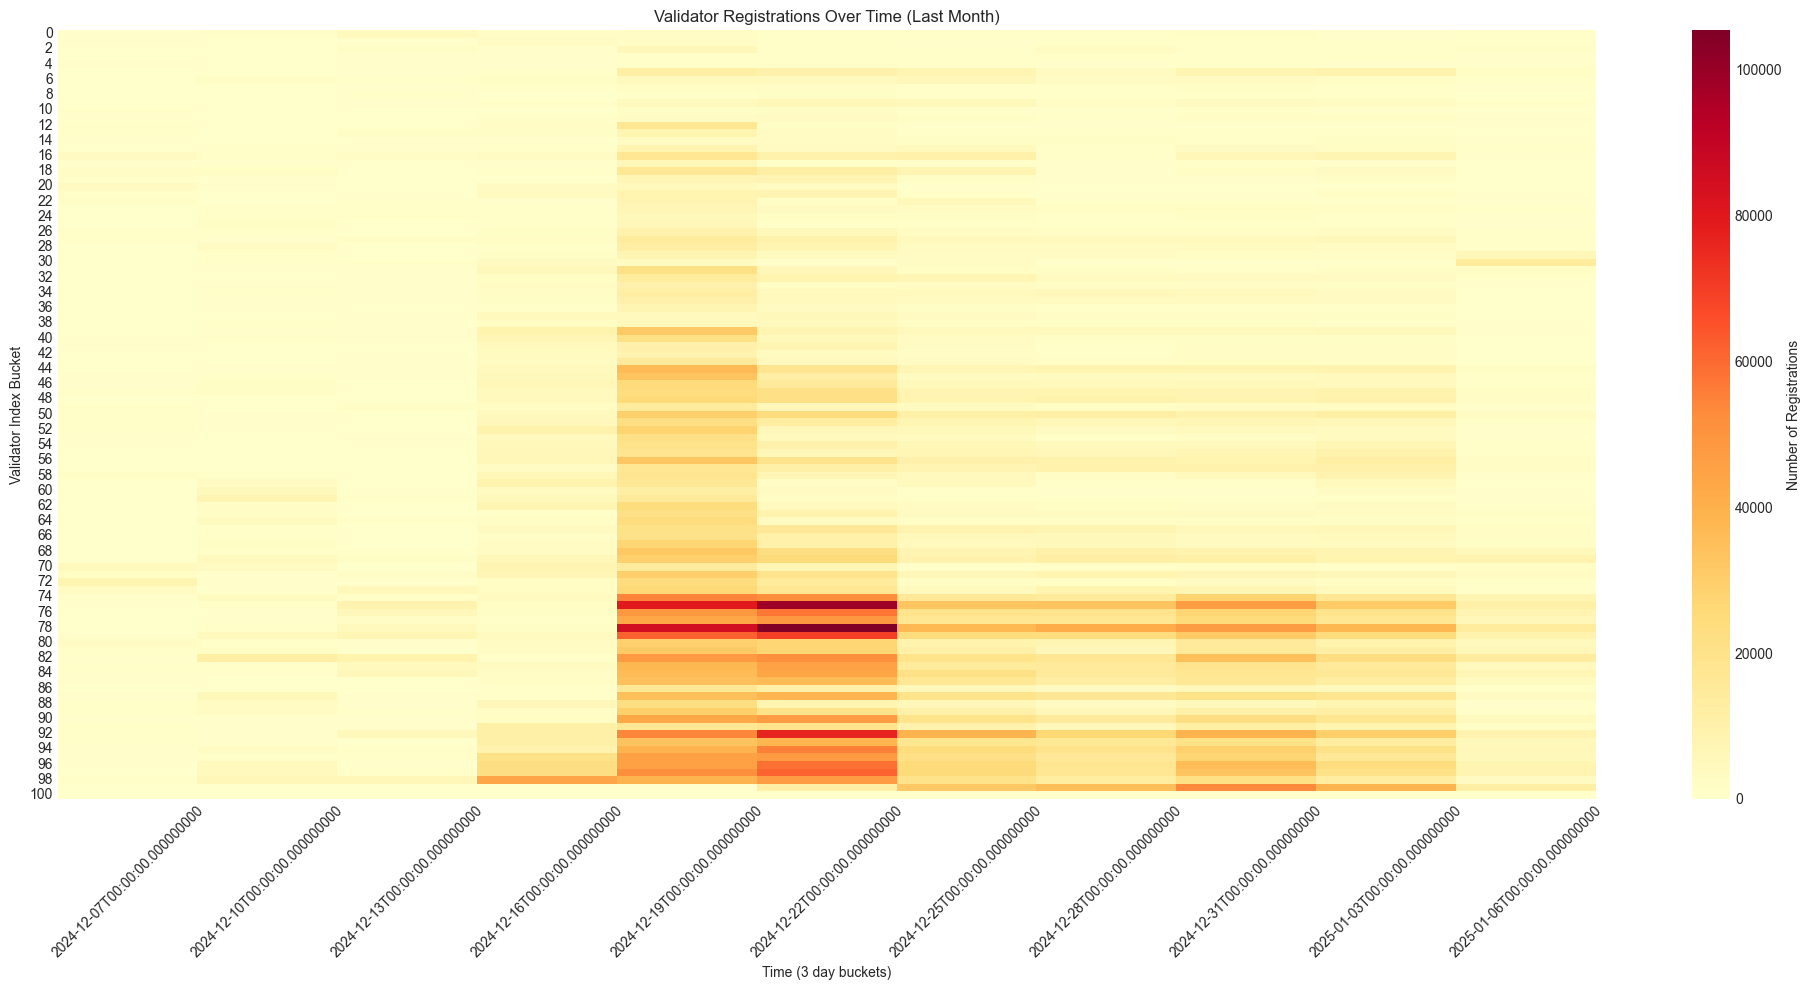

In [9]:
# Create validator buckets
n_buckets = 100
max_validator = registrations['validator_index'].max()
validator_bucket_size = max_validator // n_buckets

# Create time buckets (3 day windows)
registrations['date'] = pd.to_datetime(registrations['timestamp'], unit='s')
time_bucket_size = pd.Timedelta(days=3)
registrations['time_bucket'] = registrations['date'].dt.floor(time_bucket_size)

# Filter last month
last_month = registrations['date'].max() - pd.Timedelta(days=30)
registrations_month = registrations[registrations['date'] >= last_month]

# Create validator buckets
registrations_month['validator_bucket'] = registrations_month['validator_index'] // validator_bucket_size

# Create pivot table for heatmap
heatmap_data = registrations_month.pivot_table(
    values='validator_index', 
    index='validator_bucket',
    columns='time_bucket',
    aggfunc='count',
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, cmap='YlOrRd', cbar_kws={'label': 'Number of Registrations'})
plt.title('Validator Registrations Over Time (Last Month)')
plt.xlabel('Time (3 day buckets)')
plt.ylabel('Validator Index Bucket')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# Get most recent registration per validator
latest_registrations = (registrations
    .sort_values(['slot', 'timestamp'], ascending=[False, False])
    .groupby('validator_index')
    .first()
)
latest_registrations


,slot,gas_limit,timestamp,relay_name,entity,date,time_bucket
validator_index,,,,,,,
0,10681573,30000000,1735002899,BloXroute Max Profit,solo_stakers,2024-12-24 01:14:59,2024-12-22
1,10681573,30000000,1735002899,BloXroute Max Profit,solo_stakers,2024-12-24 01:14:59,2024-12-22
2,10681573,30000000,1735002899,BloXroute Max Profit,solo_stakers,2024-12-24 01:14:59,2024-12-22
3,10681573,30000000,1735002899,BloXroute Max Profit,solo_stakers,2024-12-24 01:14:59,2024-12-22
4,10681573,30000000,1735002899,BloXroute Max Profit,solo_stakers,2024-12-24 01:14:59,2024-12-22
...,...,...,...,...,...,...,...
1731401,10779602,30000000,1736179257,BloXroute Max Profit,None,2025-01-06 16:00:57,2025-01-06
1731402,10779603,30000000,1736179269,BloXroute Max Profit,None,2025-01-06 16:01:09,2025-01-06
1731403,10773920,30000000,1736111063,Aestus,None,2025-01-05 21:04:23,2025-01-03


In [11]:
top_entities = latest_registrations.groupby('entity').size().sort_values(ascending=False).head(100)
top_entities


entity
coinbase           101802
solo_stakers        52499
ether.fi            43314
binance             33417
kiln                29820
                    ...  
whale_0xcbfc          642
whale_0xa280          600
avado                 587
luno                  586
mercado_bitcoin       556
Length: 100, dtype: int64

In [12]:
def add_branding(fig, title=None, subtitle=None):
    # Get dimensions of input figure
    fig_width = fig.get_size_inches()[0]
    
    # Create header figure with fixed height (reduced to 25%)
    header_height = 1 # Was 2
    header_fig = plt.figure(figsize=(fig_width, header_height))
    
    # Add logos with increased size
    left_logo_ax = header_fig.add_axes([0.02, 0.2, 0.18, 0.7])  # Increased width and height
    right_logo_ax = header_fig.add_axes([0.82, 0.2, 0.16, 0.7]) # Increased width and height
    
    ethpandaops = plt.imread('../../../assets/content/ethpandaops.png')
    xatu = plt.imread('../../../assets/content/xatu.png')
    
    left_logo_ax.imshow(ethpandaops)
    right_logo_ax.imshow(xatu)
    
    left_logo_ax.axis('off')
    right_logo_ax.axis('off')
    
    # Add title and subtitle if provided
    if title:
        header_fig.text(0.5, 0.7, title, fontsize=20, fontweight='bold', ha='center')
    if subtitle:
        header_fig.text(0.5, 0.4, subtitle, fontsize=12, ha='center')
        
    # Stack figures
    combined_height = header_height + fig.get_size_inches()[1]
    combined_fig = plt.figure(figsize=(fig_width, combined_height))
    
    # Draw figures before accessing canvas
    header_fig.canvas.draw()
    fig.canvas.draw()
    
    # Copy contents using buffer_rgba instead of deprecated tostring_rgb
    header_img = np.frombuffer(header_fig.canvas.buffer_rgba(), dtype=np.uint8)
    header_img = header_img.reshape(header_fig.canvas.get_width_height()[::-1] + (4,))[:,:,:3]
    
    fig_img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    fig_img = fig_img.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:,:,:3]
    
    # Add to combined figure
    header_ax = combined_fig.add_axes([0, fig.get_size_inches()[1]/combined_height, 1, header_height/combined_height])
    content_ax = combined_fig.add_axes([0, 0, 1, fig.get_size_inches()[1]/combined_height])
    
    header_ax.imshow(header_img)
    content_ax.imshow(fig_img)
    
    header_ax.axis('off')
    content_ax.axis('off')
    
    plt.close(header_fig)
    plt.close(fig)
    
    return combined_fig

# # Create buckets from 0 to max validator index with even spacing
# max_validator = latest_registrations.index.max()
# bucket_edges = np.linspace(0, max_validator + 10000, 51) # Add padding to avoid edge effects
# bucket_labels = [(bucket_edges[i], bucket_edges[i+1]) for i in range(len(bucket_edges)-1)]

# # Count validators in each bucket
# validator_counts = pd.cut(latest_registrations.index, bins=bucket_edges).value_counts().sort_index()

# # Create heatmap data
# heatmap_data = validator_counts.values.reshape(1, -1)

# # Plot heatmap
# fig = plt.figure(figsize=(14, 8))
# ax = plt.gca()
# plt.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')
# plt.colorbar(label='Number of Validators')
# # plt.title('Number of Validators Registered per Validator Index Range', pad=40, fontweight='bold')

# # Add border
# for spine in ax.spines.values():
#     spine.set_linewidth(2)
#     spine.set_color('black')

# # Customize ticks
# plt.yticks([])
# plt.xticks(range(0, 50, 5), [f'{int(bucket_edges[i]):,}' for i in range(0, 50, 5)], rotation=45)

# # Add branding with title
# add_branding(fig, title='Number of Validators Registered per Validator Index Range', subtitle='')

# plt.show()

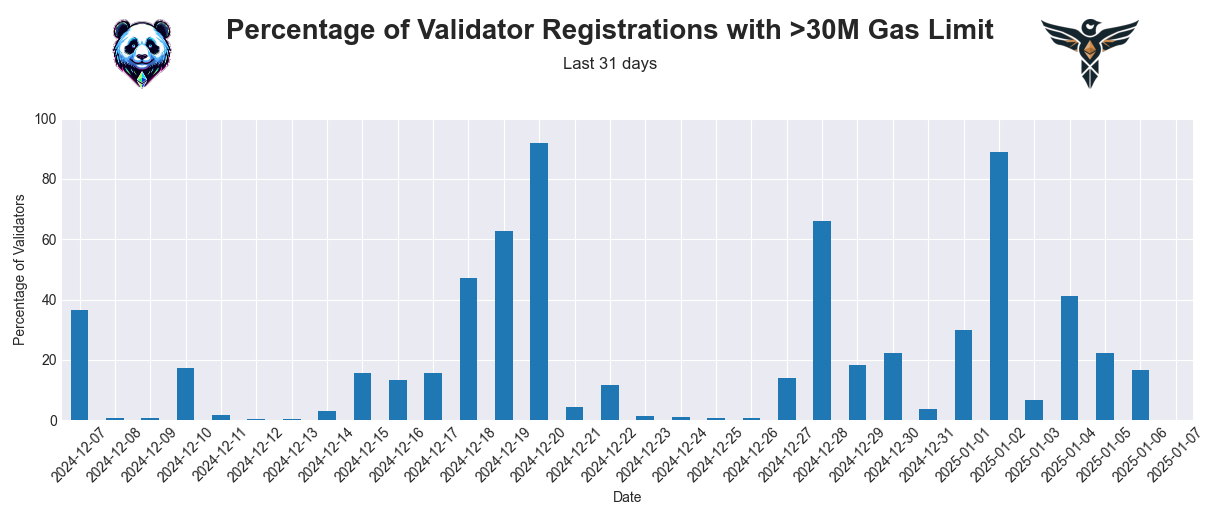

In [13]:
# Calculate percentage of high gas limit registrations over time
latest_registrations_ts = latest_registrations.copy()
latest_registrations_ts = latest_registrations_ts.set_index('timestamp') 
latest_registrations_ts.index = pd.to_datetime(latest_registrations_ts.index, unit='s').date

# Filter for last 31 days
cutoff_date = pd.Timestamp.now().date() - pd.Timedelta(days=31)
latest_registrations_31d = latest_registrations_ts[latest_registrations_ts.index >= cutoff_date]

# Group by day and calculate percentage with high gas
daily_stats = latest_registrations_31d.groupby(latest_registrations_31d.index).agg({
    'gas_limit': lambda x: (x > 30_000_000).mean() * 100
})

# Create bar plot
fig = plt.figure(figsize=(12, 4), constrained_layout=True)
daily_stats['gas_limit'].plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Percentage of Validators')
plt.grid(True)
plt.xticks(rotation=45)
plt.ylim(0, 100)
add_branding(fig, title='Percentage of Validator Registrations with >30M Gas Limit', subtitle='Last 31 days')
plt.show()


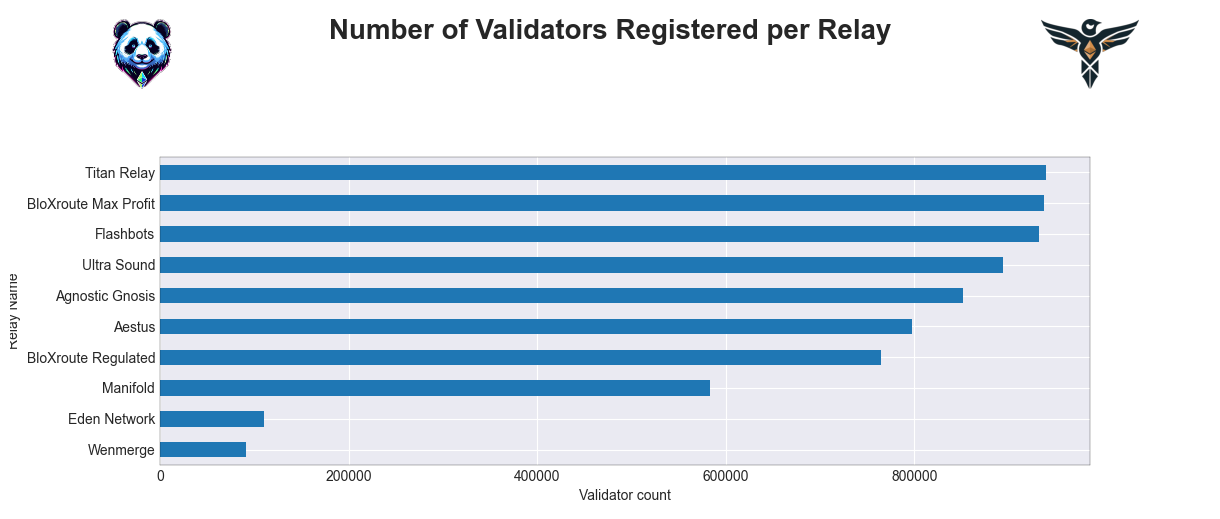

In [14]:
# Count distinct validators per relay
relay_validator_counts = registrations.groupby('relay_name')['validator_index'].nunique().sort_values(ascending=True)

# Create horizontal bar plot
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()
relay_validator_counts.plot(kind='barh')
plt.xlabel('Validator count')
plt.ylabel('Relay Name')
# plt.title('Number of Distinct Validators Registered per Relay', pad=20, fontweight='bold')
plt.grid(True, axis='x')

# Add border
for spine in ax.spines.values():
    spine.set_linewidth(0.2)
    spine.set_color('black')

# Add branding
add_branding(fig, title='Number of Validators Registered per Relay', subtitle='')

# plt.tight_layout()
plt.show()


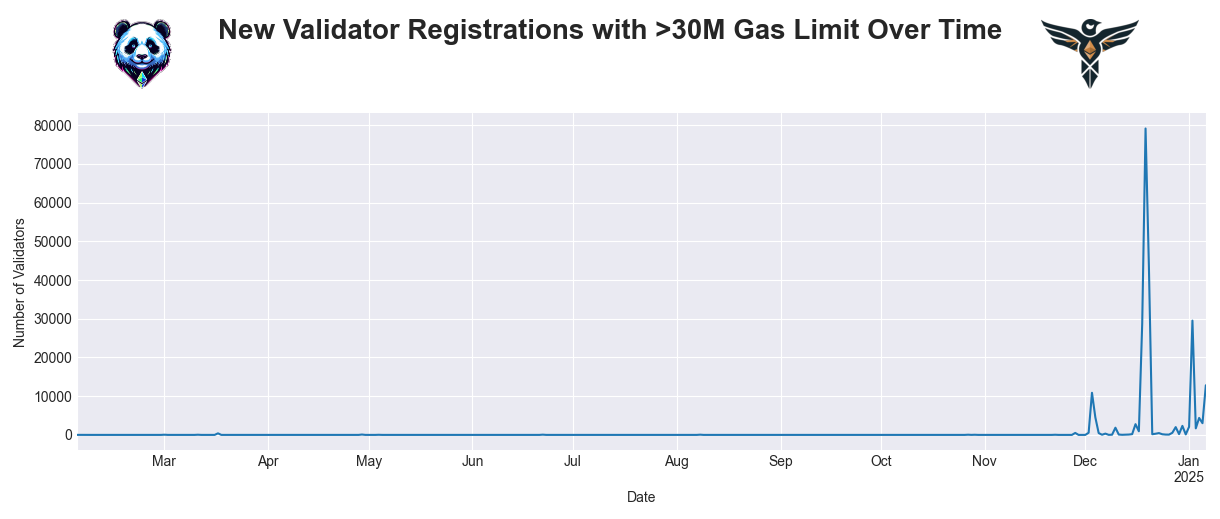

In [15]:
# Filter for high gas limit registrations
high_gas = latest_registrations[latest_registrations['gas_limit'] > 30_000_000]

# Convert timestamp to datetime index
high_gas = high_gas.set_index('timestamp')
high_gas.index = pd.to_datetime(high_gas.index, unit='s')

# Group by timestamp and count validators 
high_gas_counts = high_gas.groupby(pd.Grouper(freq='1D')).size()

# Create line plot
fig = plt.figure(figsize=(12, 4), constrained_layout=True)
high_gas_counts.plot()
plt.xlabel('Date')
plt.ylabel('Number of Validators')
# plt.title('New Validator Registrations with >30M Gas Limit Over Time', pad=10, fontweight='bold')
plt.grid(True)
add_branding(fig, title='New Validator Registrations with >30M Gas Limit Over Time', subtitle='')
plt.show()


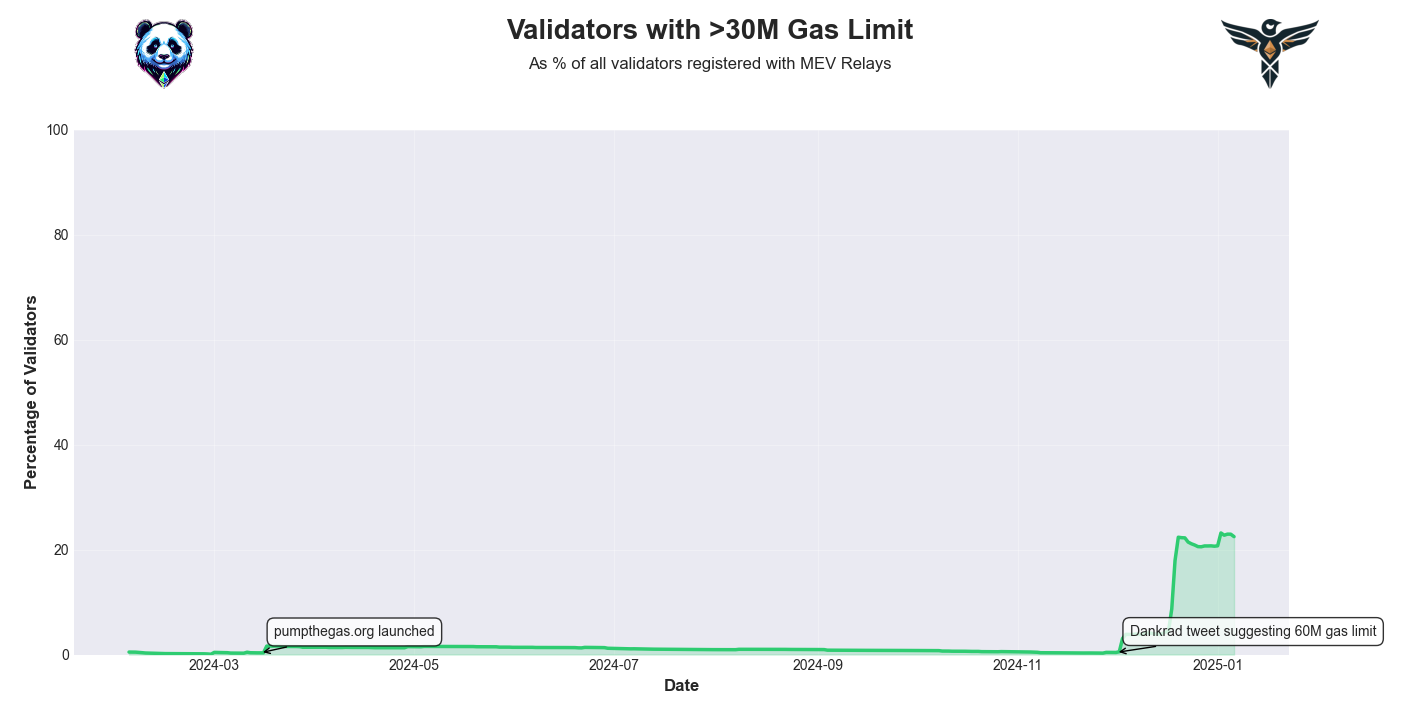

In [16]:
# Calculate cumulative percentage of validators with high gas limit
latest_with_dt = latest_registrations.copy()
latest_with_dt['timestamp'] = pd.to_datetime(latest_with_dt['timestamp'], unit='s')

# Filter for last 12 months
last_12m = pd.Timestamp.now() - pd.DateOffset(months=12)
latest_with_dt = latest_with_dt[latest_with_dt['timestamp'] >= last_12m]

# Get cumulative counts
high_gas = latest_with_dt[latest_with_dt['gas_limit'] > 30_000_000]
high_gas_counts = high_gas.groupby(pd.Grouper(freq='1D', key='timestamp')).size()
high_gas_cumsum = high_gas_counts.cumsum()
total_validators_cumsum = latest_with_dt.groupby(pd.Grouper(freq='1D', key='timestamp')).size().cumsum()

# Calculate percentage based on cumulative values and filter out days with no data
high_gas_pct = (high_gas_cumsum / total_validators_cumsum * 100).fillna(0)
high_gas_pct = high_gas_pct[high_gas_pct != 0]

# Create line plot with style
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(14, 6))
plt.plot(high_gas_pct.index, high_gas_pct.values, 
         linewidth=2.5, 
         color='#2ecc71')

plt.fill_between(high_gas_pct.index, high_gas_pct.values, 
                 alpha=0.2, 
                 color='#2ecc71')

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of Validators', fontsize=12, fontweight='bold')
plt.ylim(0, 100)

# Add annotation for pumpthegas.org launch
launch_date = pd.to_datetime('2024-03-15')
if launch_date in high_gas_pct.index:
    y_pos = high_gas_pct[high_gas_pct.index == launch_date].values[0]
    plt.annotate('pumpthegas.org launched', 
                xy=(launch_date, y_pos),
                xytext=(10, 10), textcoords='offset points',
                ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

launch_date = pd.to_datetime('2024-12-01')
if launch_date in high_gas_pct.index:
    y_pos = high_gas_pct[high_gas_pct.index == launch_date].values[0]
    plt.annotate('Dankrad tweet suggesting 60M gas limit', 
                xy=(launch_date, y_pos),
                xytext=(10, 10), textcoords='offset points',
                ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tick_params(axis='both', labelsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
add_branding(fig, title='Validators with >30M Gas Limit', subtitle='As % of all validators registered with MEV Relays')
plt.show()


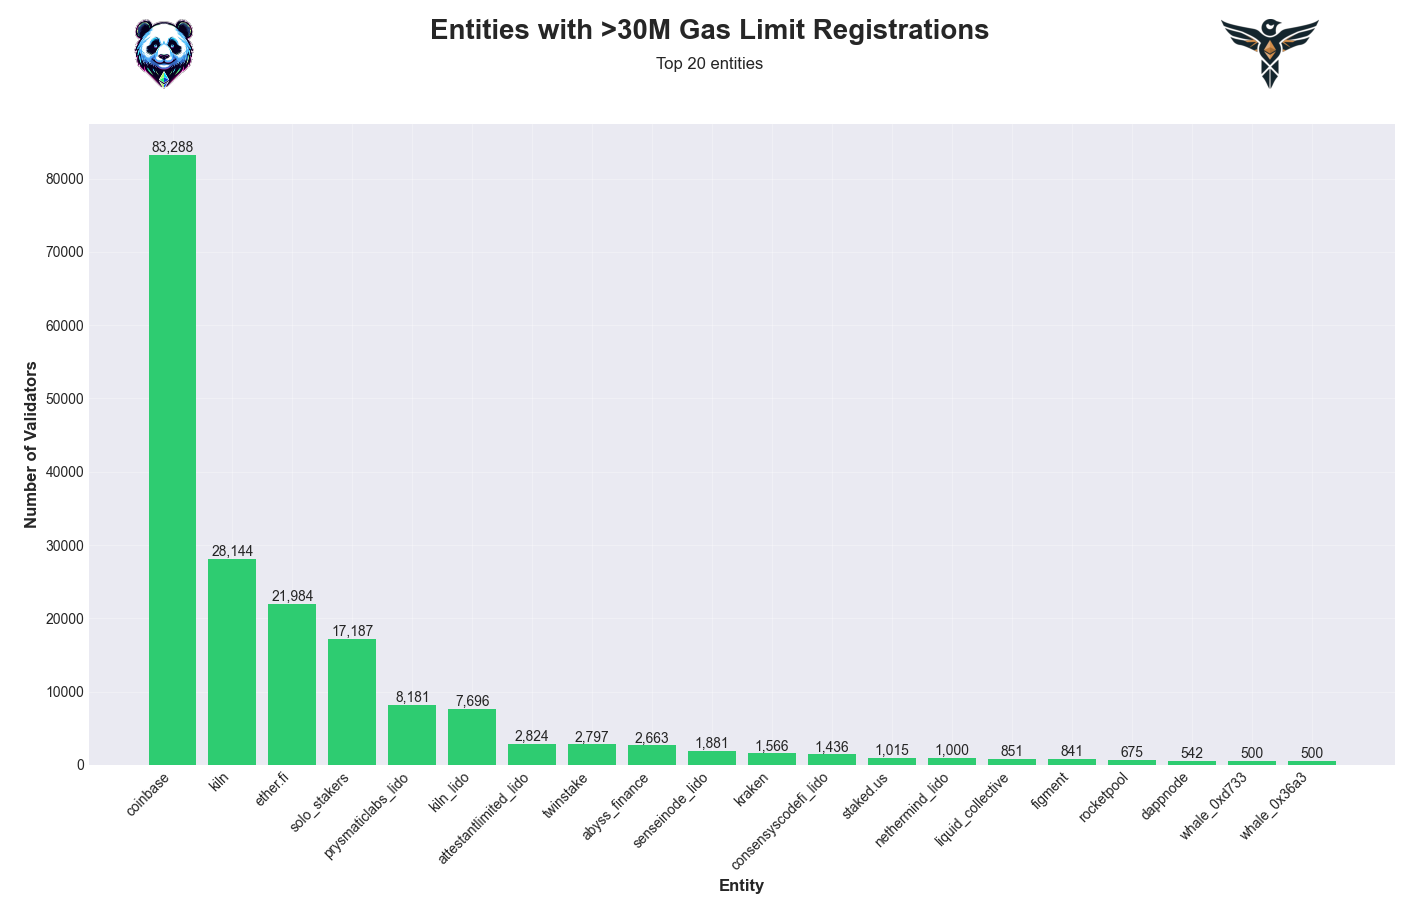

In [17]:
# Get top 20 entities with high gas limit
top_entities = high_gas.groupby('entity').size().sort_values(ascending=False).head(20)

# Create bar plot with style
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(14, 8))

bars = plt.bar(range(len(top_entities)), top_entities.values, color='#2ecc71')
plt.xticks(range(len(top_entities)), top_entities.index, rotation=45, ha='right')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

plt.xlabel('Entity', fontsize=12, fontweight='bold')
plt.ylabel('Number of Validators', fontsize=12, fontweight='bold')
plt.tick_params(axis='both', labelsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
add_branding(fig, title='Entities with >30M Gas Limit Registrations', subtitle='Top 20 entities')
plt.show()


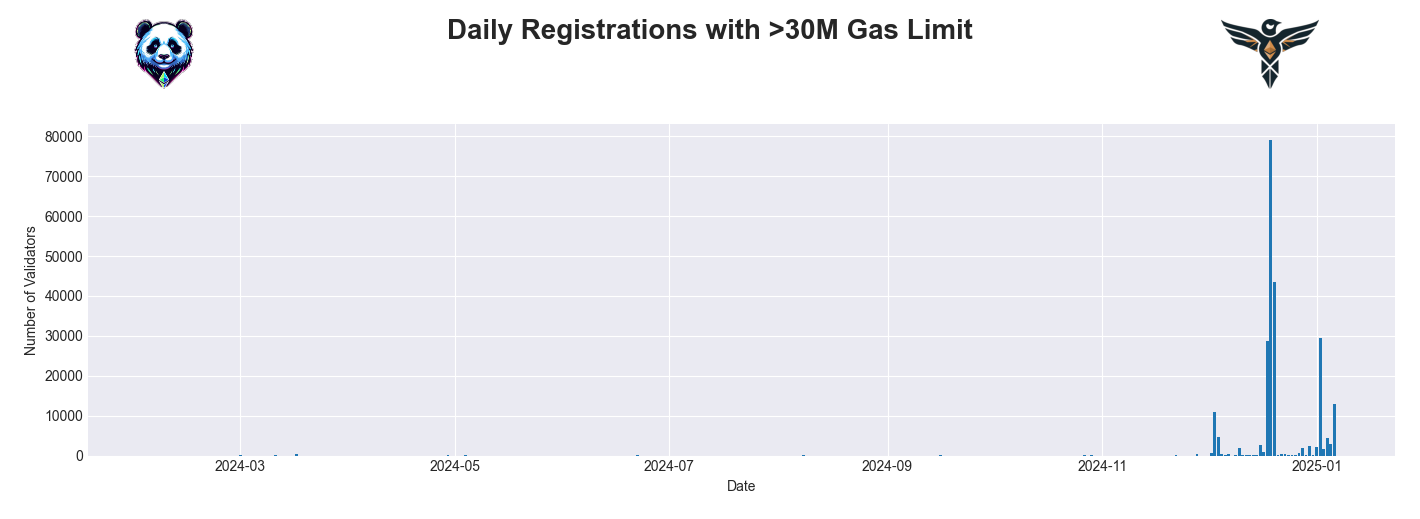

In [18]:
# Count unique validators per day
daily_validator_counts = high_gas.reset_index()
daily_validator_counts['timestamp'] = pd.to_datetime(daily_validator_counts['timestamp'], unit='s')
daily_counts = daily_validator_counts.groupby(
    pd.Grouper(freq='1D', key='timestamp')
).size().reset_index(name='validator_count')

# Create bar plot
fig = plt.figure(figsize=(14, 4))
plt.bar(daily_counts['timestamp'], daily_counts['validator_count'])

plt.xlabel('Date')
plt.ylabel('Number of Validators')
# plt.title('Daily Validators with >30M Gas Limit Registrations')
plt.grid(True)
plt.tight_layout()
add_branding(fig, title='Daily Registrations with >30M Gas Limit', subtitle='')
plt.show()


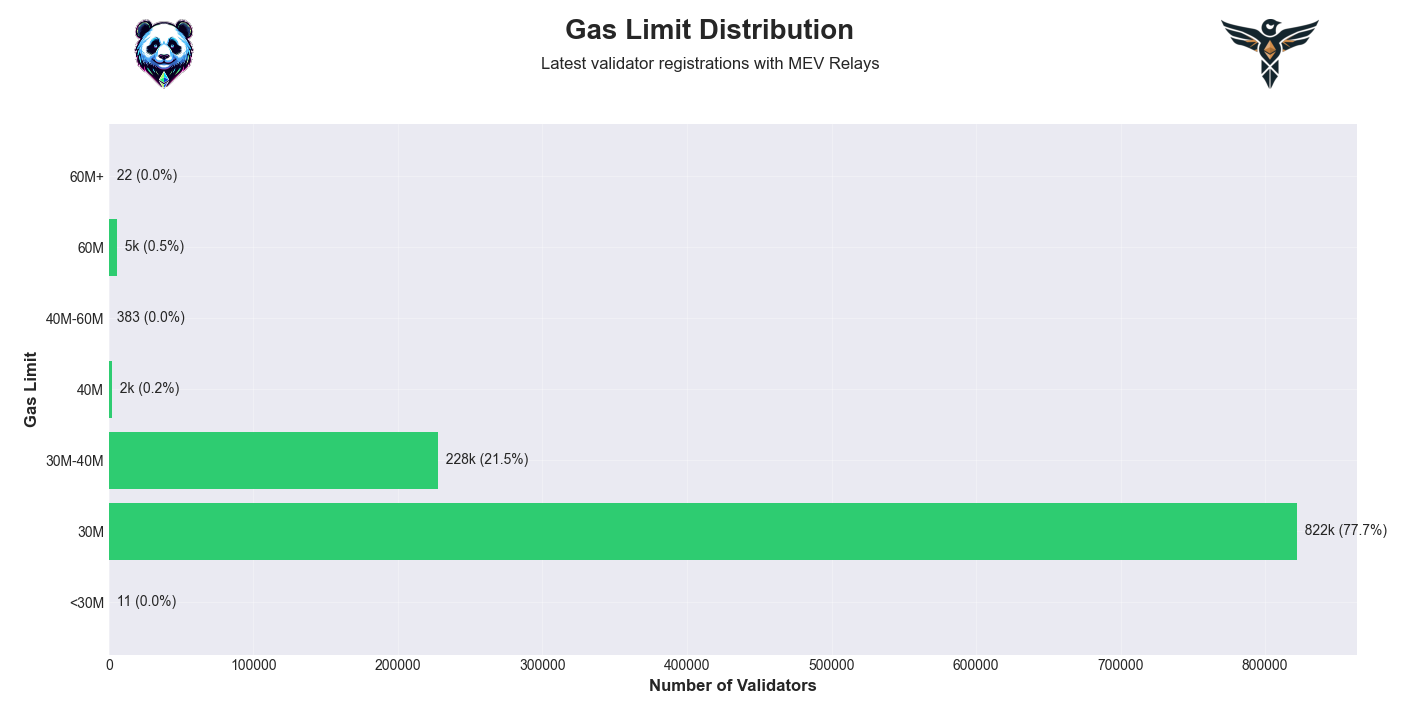

In [19]:
# Create gas limit buckets
def get_gas_bucket(gas):
    if gas < 30_000_000:
        return '<30M'
    elif gas == 30_000_000:
        return '30M'
    elif 30_000_000 < gas < 40_000_000:
        return '30M-40M'
    elif gas == 40_000_000:
        return '40M'
    elif 40_000_000 < gas < 60_000_000:
        return '40M-60M'
    elif gas == 60_000_000:
        return '60M'
    else:
        return '60M+'

# Get most recent registration per validator
df_latest = registrations.sort_values('timestamp').groupby('validator_index').last().reset_index()

# Add gas bucket column and count validators per bucket
df_latest['gas_bucket'] = df_latest['gas_limit'].apply(get_gas_bucket)
bucket_order = ['<30M', '30M', '30M-40M', '40M', '40M-60M', '60M', '60M+']
bucket_counts = df_latest['gas_bucket'].value_counts()[bucket_order]

# Calculate percentages
total = bucket_counts.sum()
percentages = bucket_counts / total * 100

# Create horizontal bar chart
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(14, 6))

bars = plt.barh(bucket_order, bucket_counts, color='#2ecc71')

# Add value labels on bars
for i, (count, pct) in enumerate(zip(bucket_counts, percentages)):
    # Format count label
    if count >= 1_000_000:
        count_text = f'{count/1_000_000:.1f}M'
    elif count >= 1_000:
        count_text = f'{count/1_000:.0f}k'
    else:
        count_text = str(count)
        
    # Add count and percentage
    plt.text(count, i, f'  {count_text} ({pct:.1f}%)', 
             va='center', fontsize=10)

plt.xlabel('Number of Validators', fontsize=12, fontweight='bold')
plt.ylabel('Gas Limit', fontsize=12, fontweight='bold')
plt.tick_params(axis='both', labelsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
add_branding(fig, title='Gas Limit Distribution', subtitle='Latest validator registrations with MEV Relays')
plt.show()


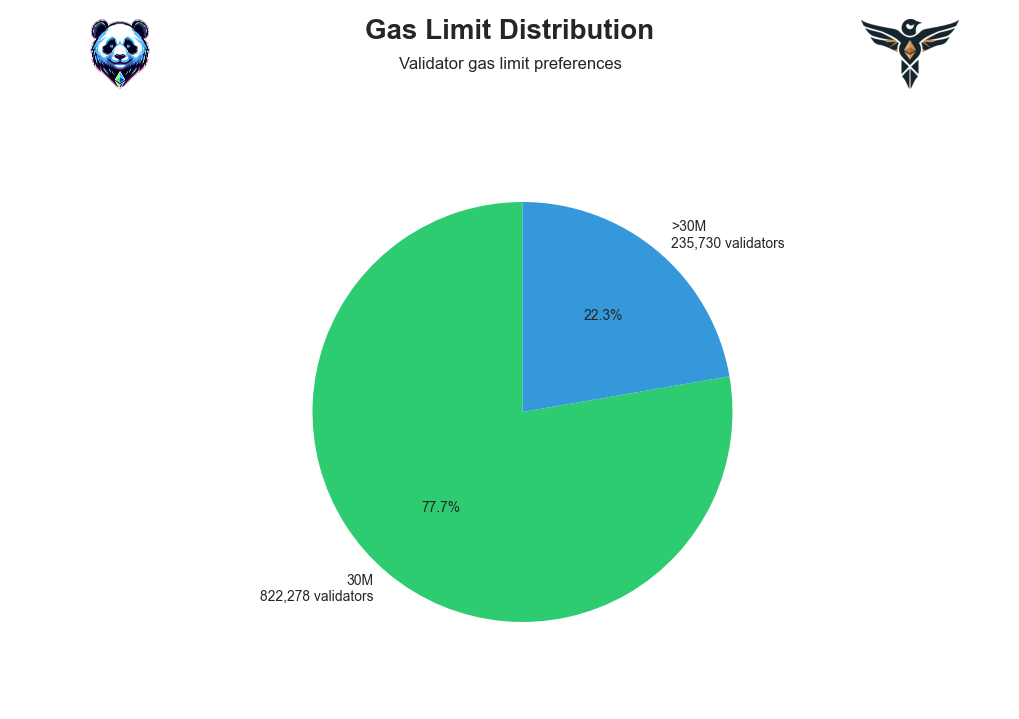

In [20]:
# Get most recent registration per validator
df_latest = registrations.sort_values('timestamp').groupby('validator_index').last().reset_index()

# Add gas bucket column and count validators per bucket
df_latest['gas_bucket'] = df_latest['gas_limit'].apply(lambda x: '30M' if x == 30_000_000 else '>30M')
bucket_order = ['30M', '>30M']
bucket_counts = df_latest['gas_bucket'].value_counts()[bucket_order]

# Calculate percentages
total = bucket_counts.sum()
percentages = bucket_counts / total * 100

# Create pie chart
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(10, 6))

plt.pie(bucket_counts, labels=[f'{label}\n{count:,} validators' for label, count in zip(bucket_order, bucket_counts)],
        colors=['#2ecc71', '#3498db'],
        autopct='%1.1f%%', startangle=90)

plt.axis('equal')
add_branding(fig, title='Gas Limit Distribution', subtitle='Validator gas limit preferences')
plt.show()


In [21]:
# Get most recent registration per validator
df_latest = registrations.sort_values('timestamp').groupby('validator_index').last().reset_index()

# Add gas bucket column and count validators per bucket
df_latest['gas_bucket'] = df_latest['gas_limit'].apply(get_gas_bucket)
bucket_order = ['<30M', '30M', '30M-36M', '36M', '36M-60M', '60M', '60M+']
bucket_counts = df_latest['gas_bucket'].value_counts()[bucket_order]

# Calculate percentages
total = bucket_counts.sum()
percentages = (bucket_counts / total * 100).round(2)

# Create heatmap plot
plt.style.use('seaborn-v0_8-dark')
plt.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=(12, 2))
plt.imshow([percentages], cmap='YlOrRd', aspect='auto')

plt.xlabel('Gas Limit', fontsize=12, fontfamily='Helvetica')

# Add value labels in cells
for i, pct in enumerate(percentages):
    text_color = 'white' if pct > 10 else 'black'
    plt.text(i, 0, f'{pct}%', ha='center', va='center', color=text_color, 
             fontweight='bold', fontfamily='Helvetica')

plt.xticks(range(len(bucket_order)), bucket_order, rotation=0, fontfamily='Helvetica')
plt.yticks([])
plt.colorbar(label='Percentage of Validators').set_label(label='Percentage of Validators', 
                                                        fontfamily='Helvetica')
plt.tight_layout()
add_branding(fig, title='Gas Limit Distribution (%)', subtitle='Validators registered with MEV Relays')
plt.show()


KeyError: "['30M-36M', '36M', '36M-60M'] not in index"